In [1]:
import arviz as az 
import matplotlib.pyplot as plt
import numpy as np 
import pymc3 as pm 
import theano.tensor as tt 
import warnings 

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print("Running on PyMC3 v{}".format(pm.__version__))
print('Running on Arviz v{}'.format(az.__version__))

Running on PyMC3 v3.9.0
Running on Arviz v0.9.0


Statistical models are instances of `Model` class

In [10]:
np.random.seed(101)

with pm.Model() as model:
    # model definition goes in context
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu = mu, sigma = 1, observed = np.random.randn(100))

print("basic RVs: ",model.basic_RVs) # all RVs
print("free RVs: ",model.free_RVs) # not observed
print("observed RVs: ",model.observed_RVs) # observed

basic RVs:  [mu, obs]
free RVs:  [mu]
observed RVs:  [obs]


View the model's log-probability evaluated at the passed value argument. This model log-probability (function) is used for fitting models.

In [15]:
model.logp({"mu":0})

array(-147.63581906)

Every probabilistic program hass observed and unobserved RVs.
* observed RVs are defined via likelihood dists
* unobserved RVs are defined via prior dists

In [16]:
# help(pm.Normal)

In [18]:
# pymc3.distributions. (continuous, discrete, timeseries, mixture)
dir(pm.distributions.continuous)

['Beta',
 'BoundedContinuous',
 'Cauchy',
 'ChiSquared',
 'Continuous',
 'ExGaussian',
 'Exponential',
 'Flat',
 'Gamma',
 'Gumbel',
 'HalfCauchy',
 'HalfFlat',
 'HalfNormal',
 'HalfStudentT',
 'Interpolated',
 'InterpolatedUnivariateSpline',
 'InverseGamma',
 'Kumaraswamy',
 'Laplace',
 'Logistic',
 'LogitNormal',
 'Lognormal',
 'Moyal',
 'Normal',
 'Pareto',
 'PositiveContinuous',
 'Rice',
 'SkewNormal',
 'SplineWrapper',
 'StudentT',
 'Triangular',
 'TruncatedNormal',
 'Uniform',
 'UnitContinuous',
 'VonMises',
 'Wald',
 'Weibull',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'alltrue_elemwise',
 'assert_negative_support',
 'betaln',
 'bound',
 'clipped_beta_rvs',
 'draw_values',
 'expit',
 'floatX',
 'gammaln',
 'generate_samples',
 'get_tau_sigma',
 'get_variable_name',
 'i0e',
 'incomplete_beta',
 'invlogit',
 'log_i0',
 'logdiffexp',
 'logit',
 'logpow',
 'normal_lccdf',
 'normal_lcdf',
 'np',
 'st

For unobserved RVs, we must pass it a name string and some parameter keyword arguments.

In [21]:
with pm.Model():
    x = pm.Normal("x", mu = 0, sigma = 1)

x.logp({"x":0}) # we can eval this since it's a dist

array(-0.91893853)

For observed RVs, we must pass data into the RV initializer

In [25]:
with pm.Model():
    obs = pm.Normal("x", mu = 0, sigma = 1, observed=np.random.randn(100))
    # What is the actual random variable here? It's a variable x which is normally distributed
    # according to the params we passed in, and we are also telling it that we have some observations/data

obs.logp({"x":0})

array(-150.93216352)

In [40]:
obs.__dir__()
# obs.observations
# obs.model
type(obs)


pymc3.model.ObservedRV

We can do algebra with RVs, i.e., deterministic transformations:

In [41]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

type(plus_2)

theano.tensor.var.TensorVariable

Important: the results of these transformations are not tracked/stored. We need to use `pm.Deterministic`.

In [52]:
with pm.Model() as model:
    x = pm.Normal("x", mu = 0, sigma = 1)
    plus_2 = pm.Deterministic('x_plus_2', x + 2)

type(plus_2)
model

There is a great deal of space in this tutorial devoted to handling transformations of distributions.

To perform sampling in `PyMC3`, use the `pm.sample` function. It tries to auto-assign the appropriate samplers, and will auto-initialize if we didn't set a `<var>.tag.test_value`.

In [58]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1) # prior
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100)) # likelihood

    idata = pm.sample(draws = 2000, tune = 1500, cores = 4, chains=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_500 tune and 2_000 draw iterations (9_000 + 12_000 draws total) took 24 seconds.


* `draws` is the number of samples taken from the posterior in each chain
* `tune` is number of iterations in which the sample can adjust its parameters. Tuning samples are discarded.
* without specifying `cores`, number of chains is determined by number of CPU cores

In [59]:
idata.posterior["mu"].shape

(6, 2000)

In [61]:
idata.posterior["mu"].sel(chain=1).shape

(2000,)

In [65]:
# see samplers
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))


['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

`NUTS` should be used for almost all continuous models.

We can use different methods when sampling, and we can even use specific methods for sampling different variables:

In [66]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    s1 = pm.Metropolis(vars=[mu])
    s2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[s1,s1], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [mu]
>NUTS: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.


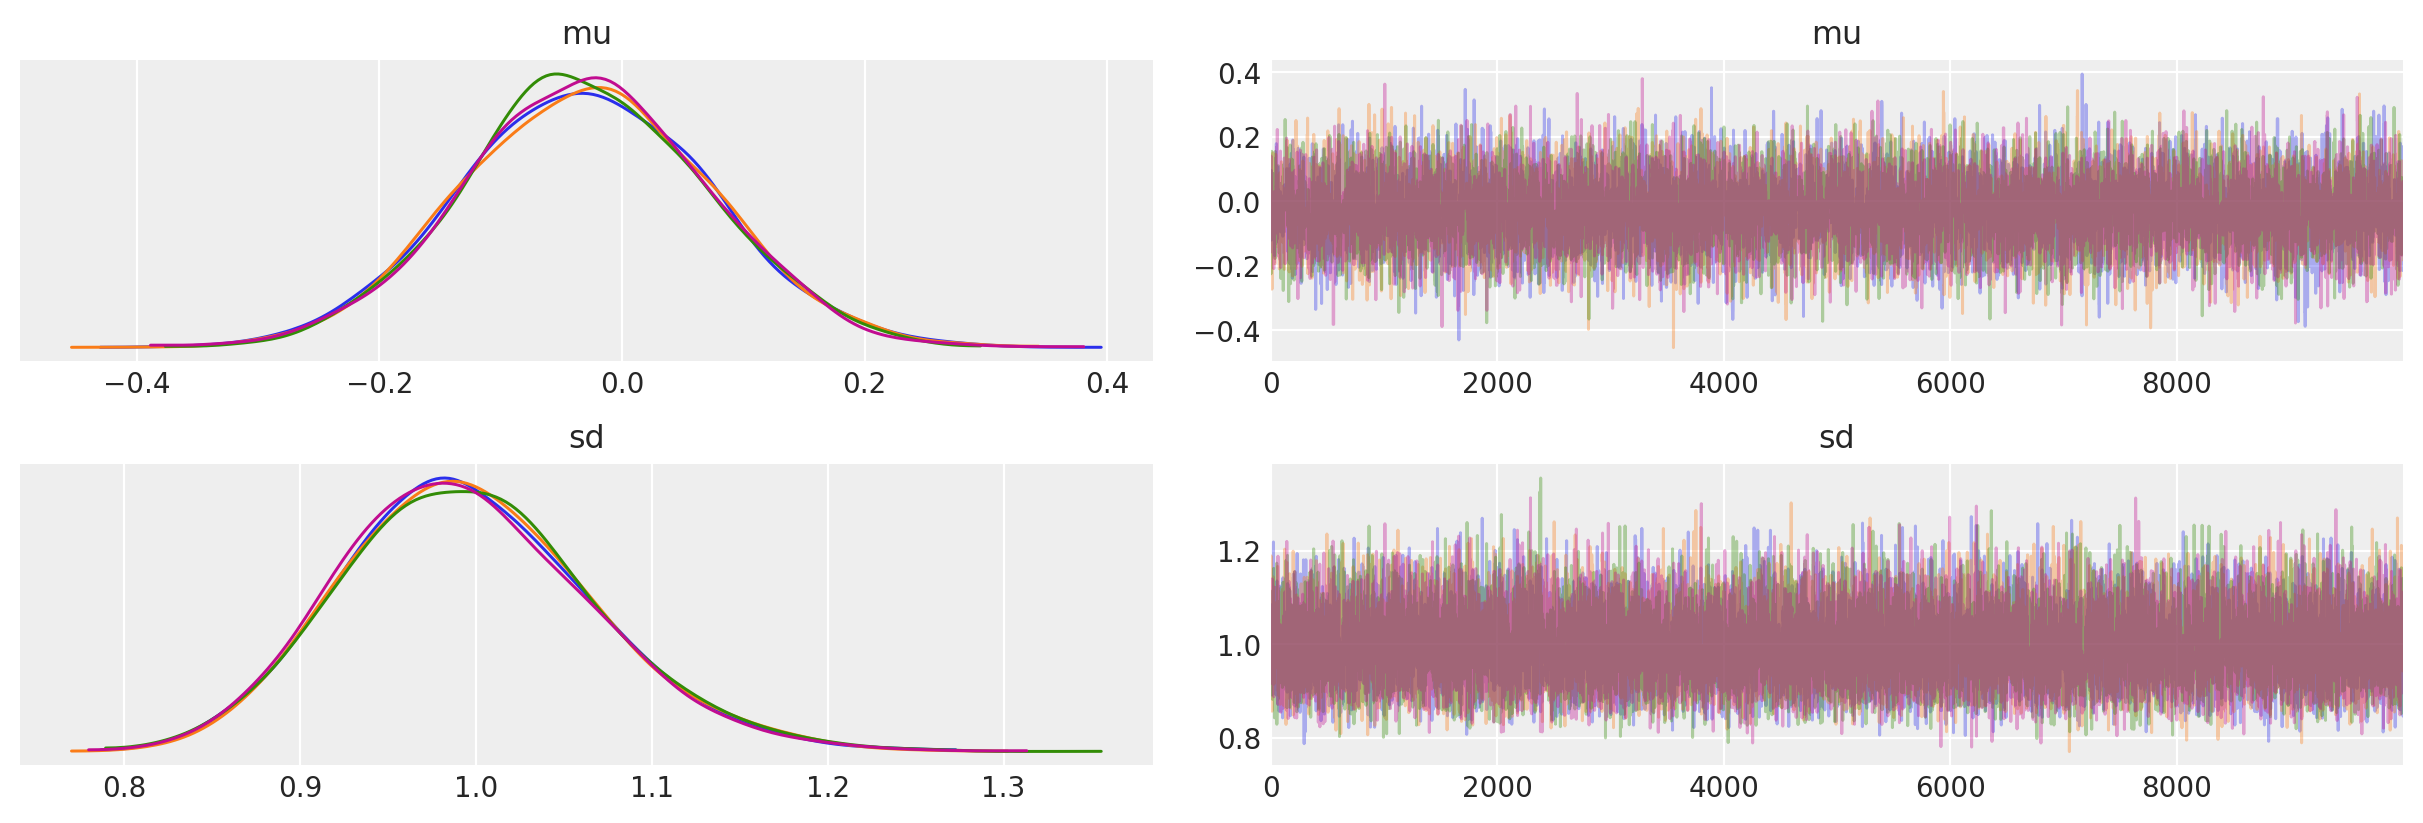

In [69]:
az.plot_trace(idata); # plot each trace

In [70]:
az.summary(idata) # Rhat is gelman-rubin statistic

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.029,0.100,-0.217,0.159,0.001,0.001,13220.0,11576.0,13200.0,14309.0,1.0
sd,0.996,0.071,0.867,1.133,0.001,0.000,16592.0,16592.0,16662.0,27382.0,1.0


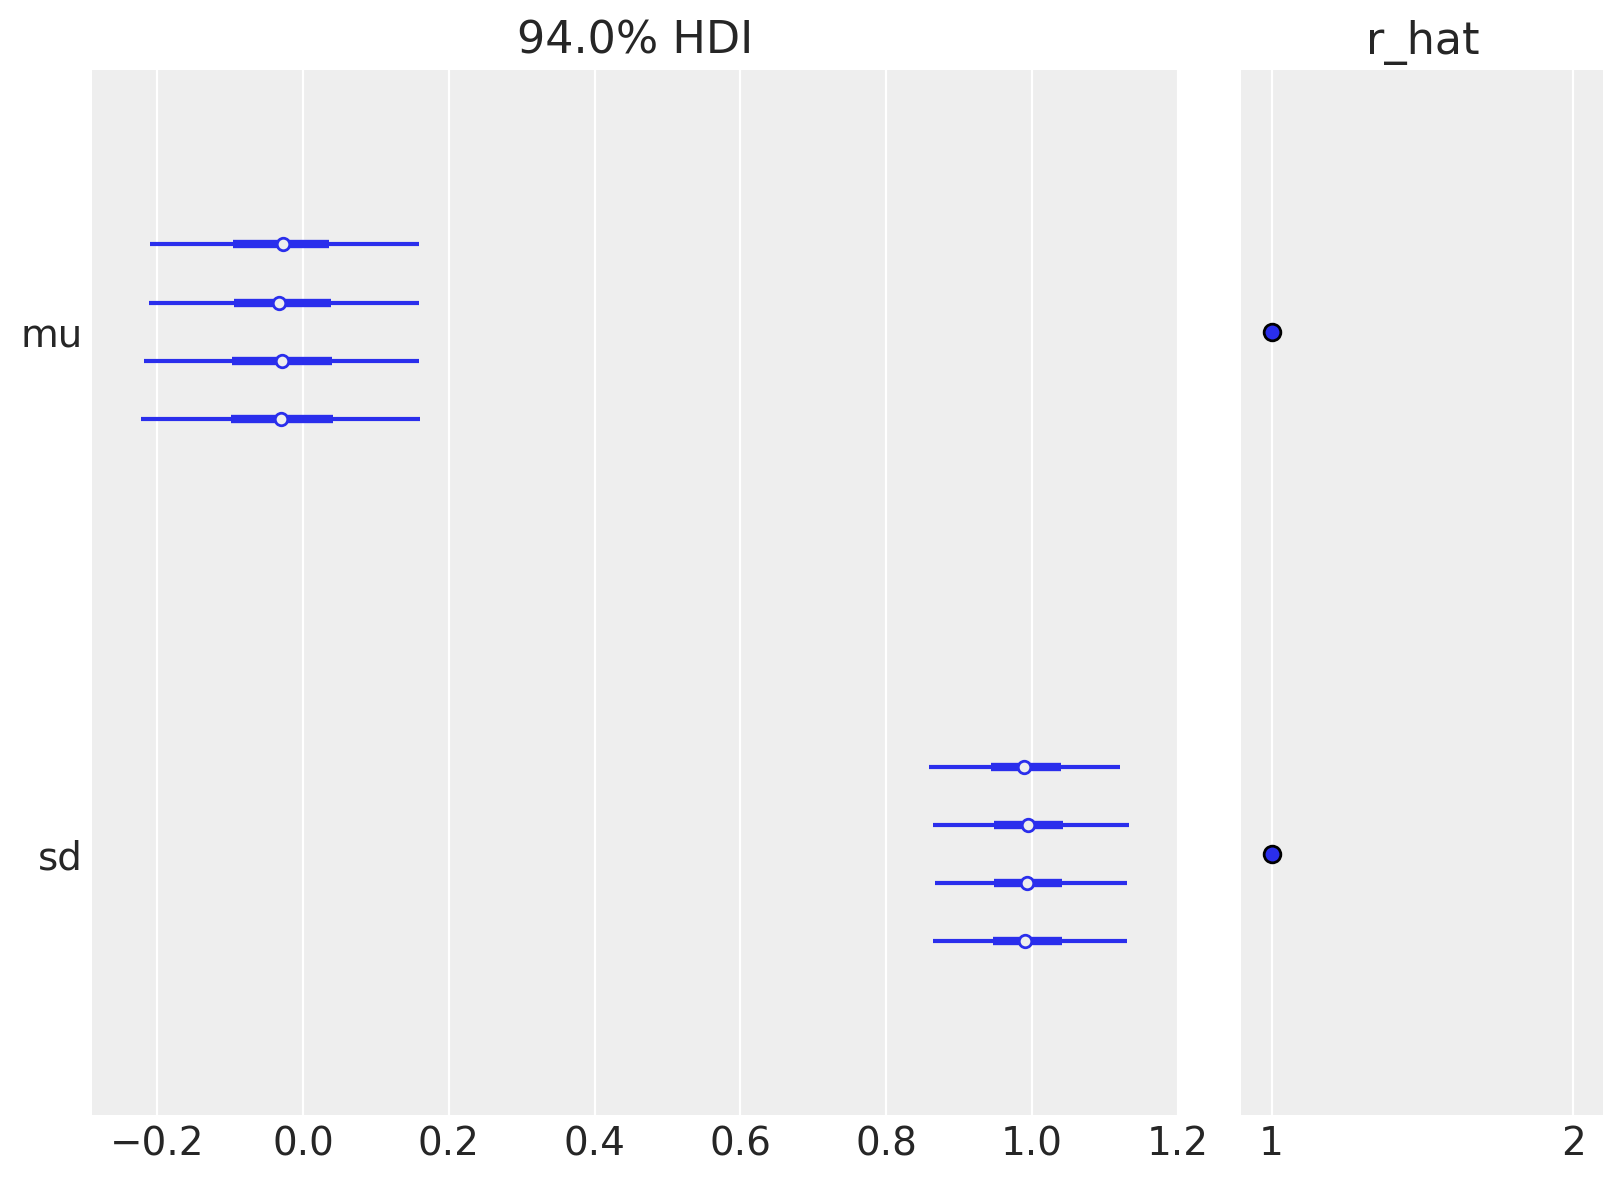

In [72]:
az.plot_forest(idata, r_hat=True);

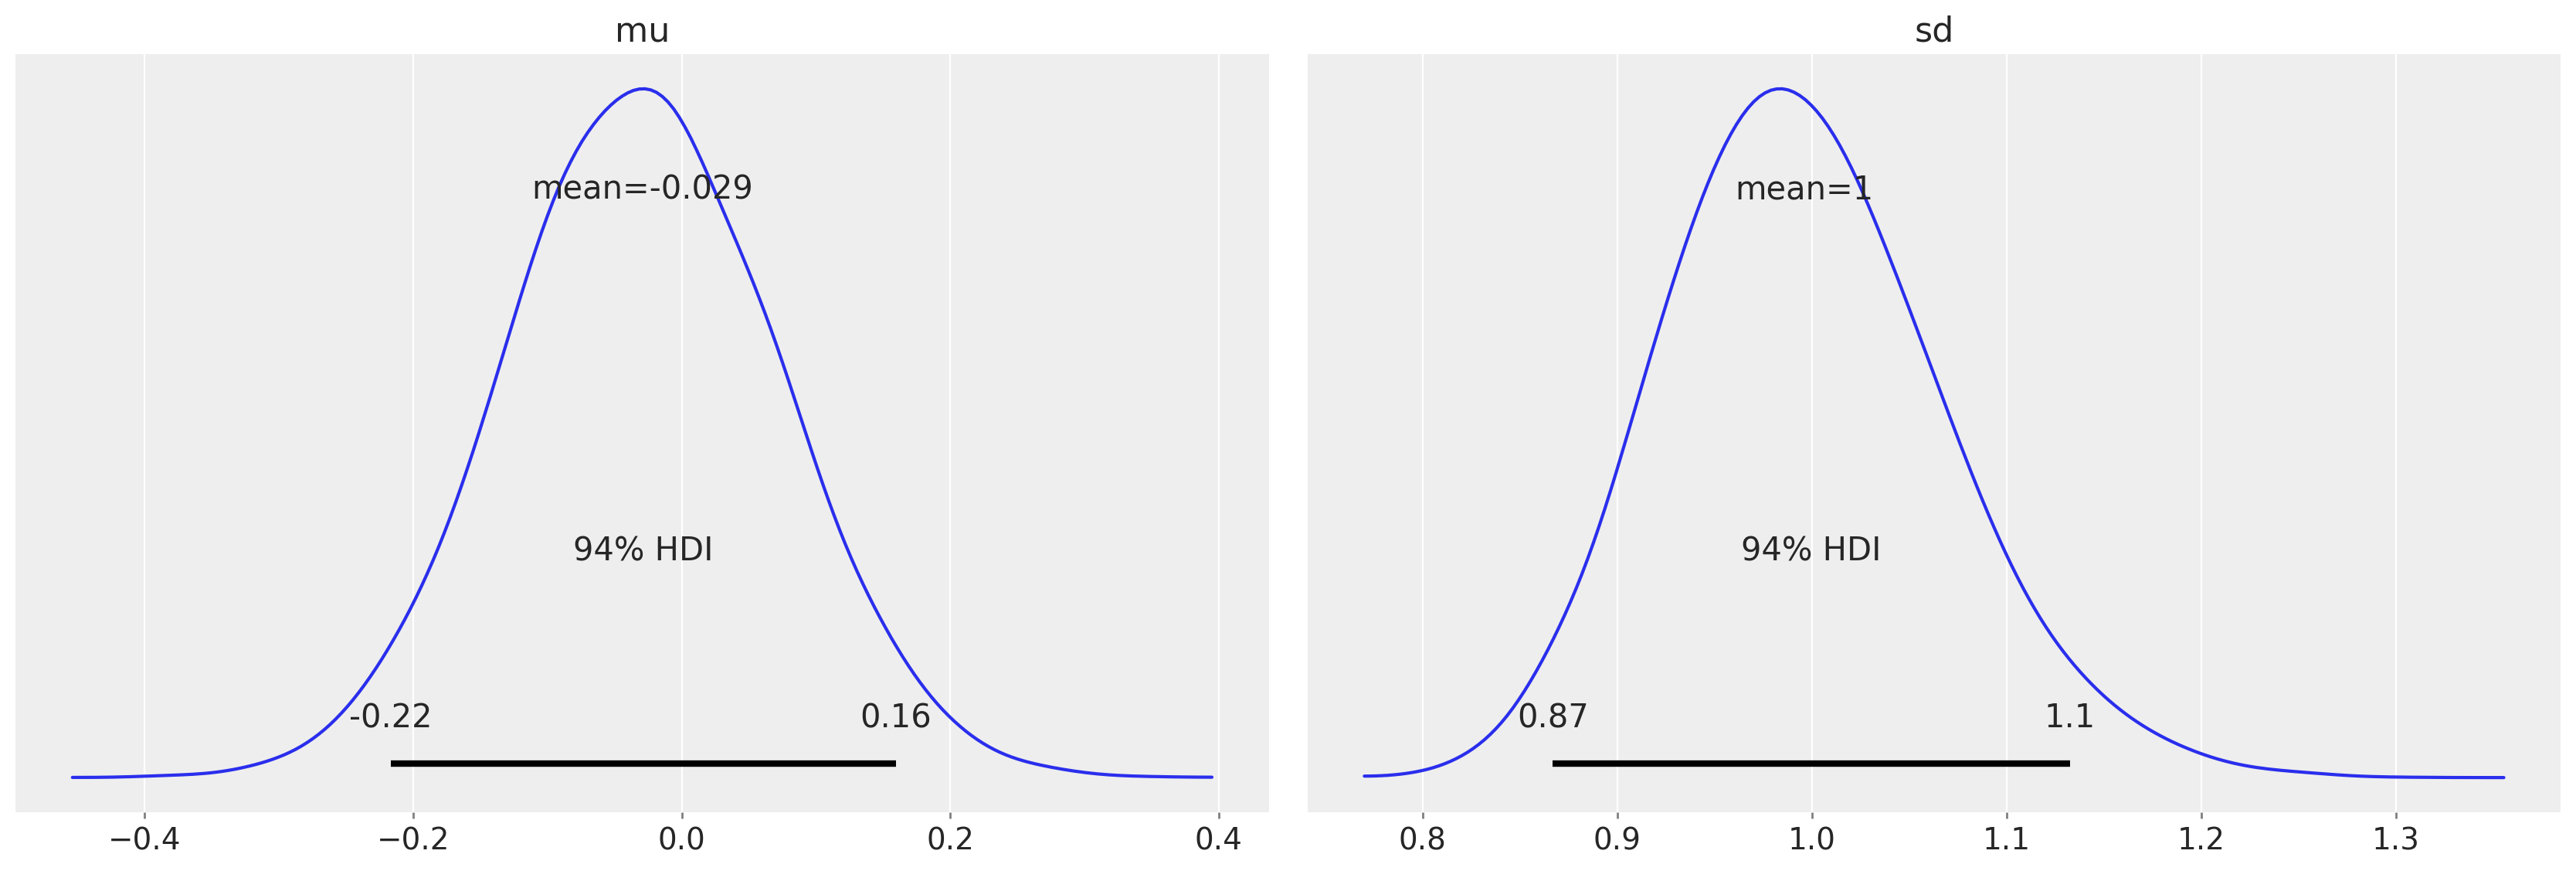

In [73]:
az.plot_posterior(idata);

With `NUTS`, look at energy plot to asses convergence issues:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


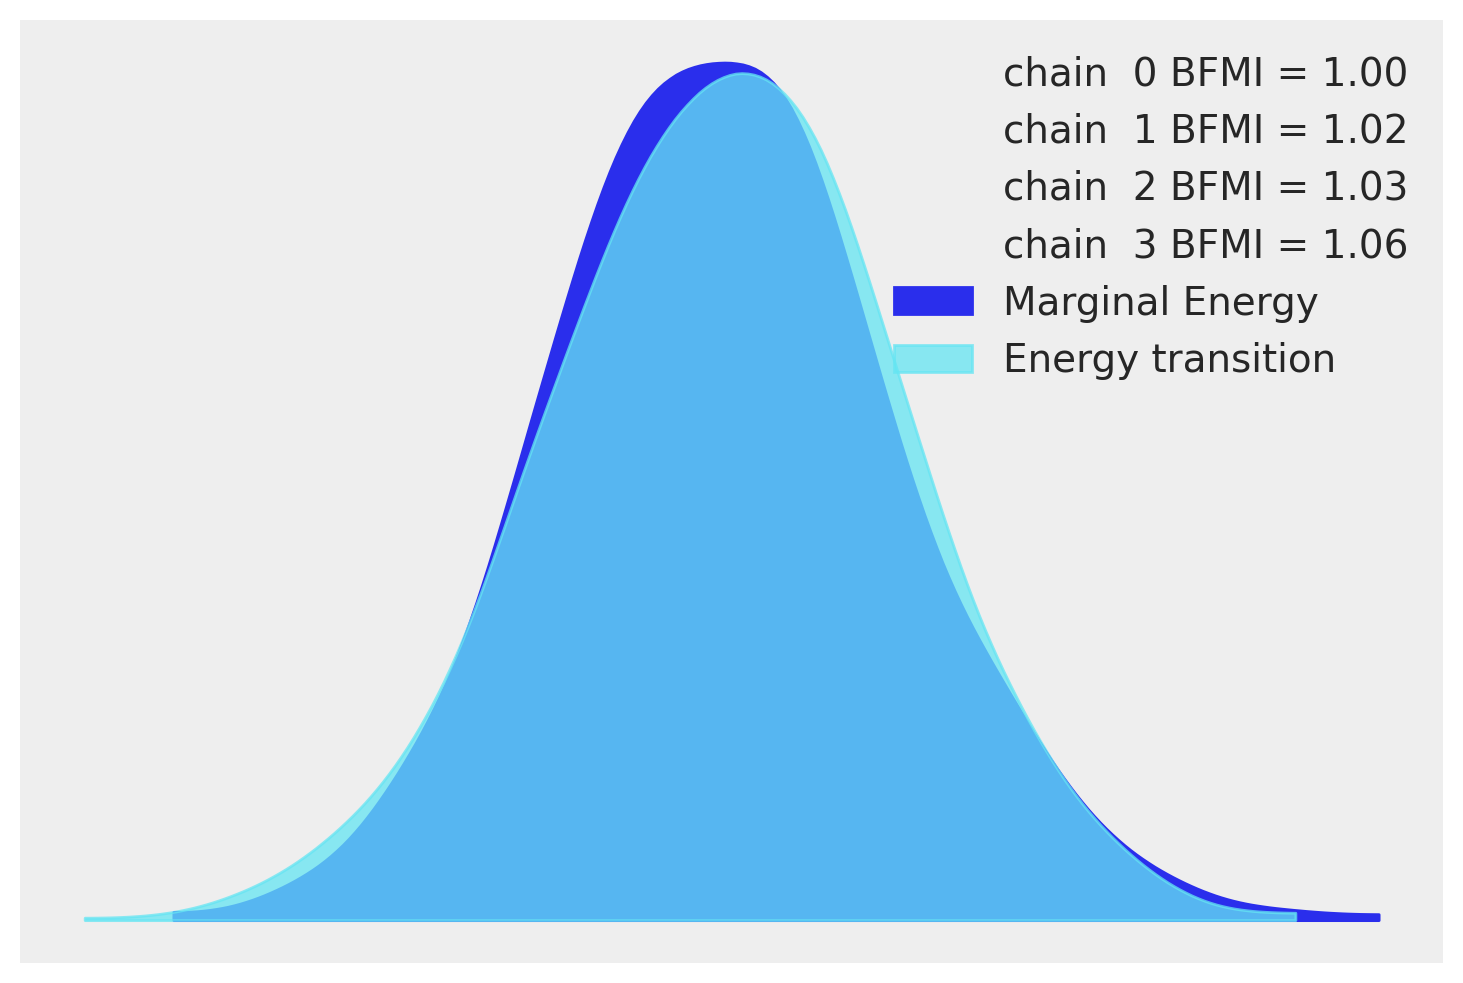

In [75]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=100)
    idata = pm.sample(cores=4, return_inferencedata=True)

az.plot_energy(idata);

`PyMC3` supports variational inference which is easily used via the `pm.fit()` function. This fits an approximation to the posterior. We can sample from the posterior in the usual way, via `sample()`

`sample_posterior_predictive()` predicts on hold-out data and performs posterior predictive checks (what does this mean?).

In [76]:
data=np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [77]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

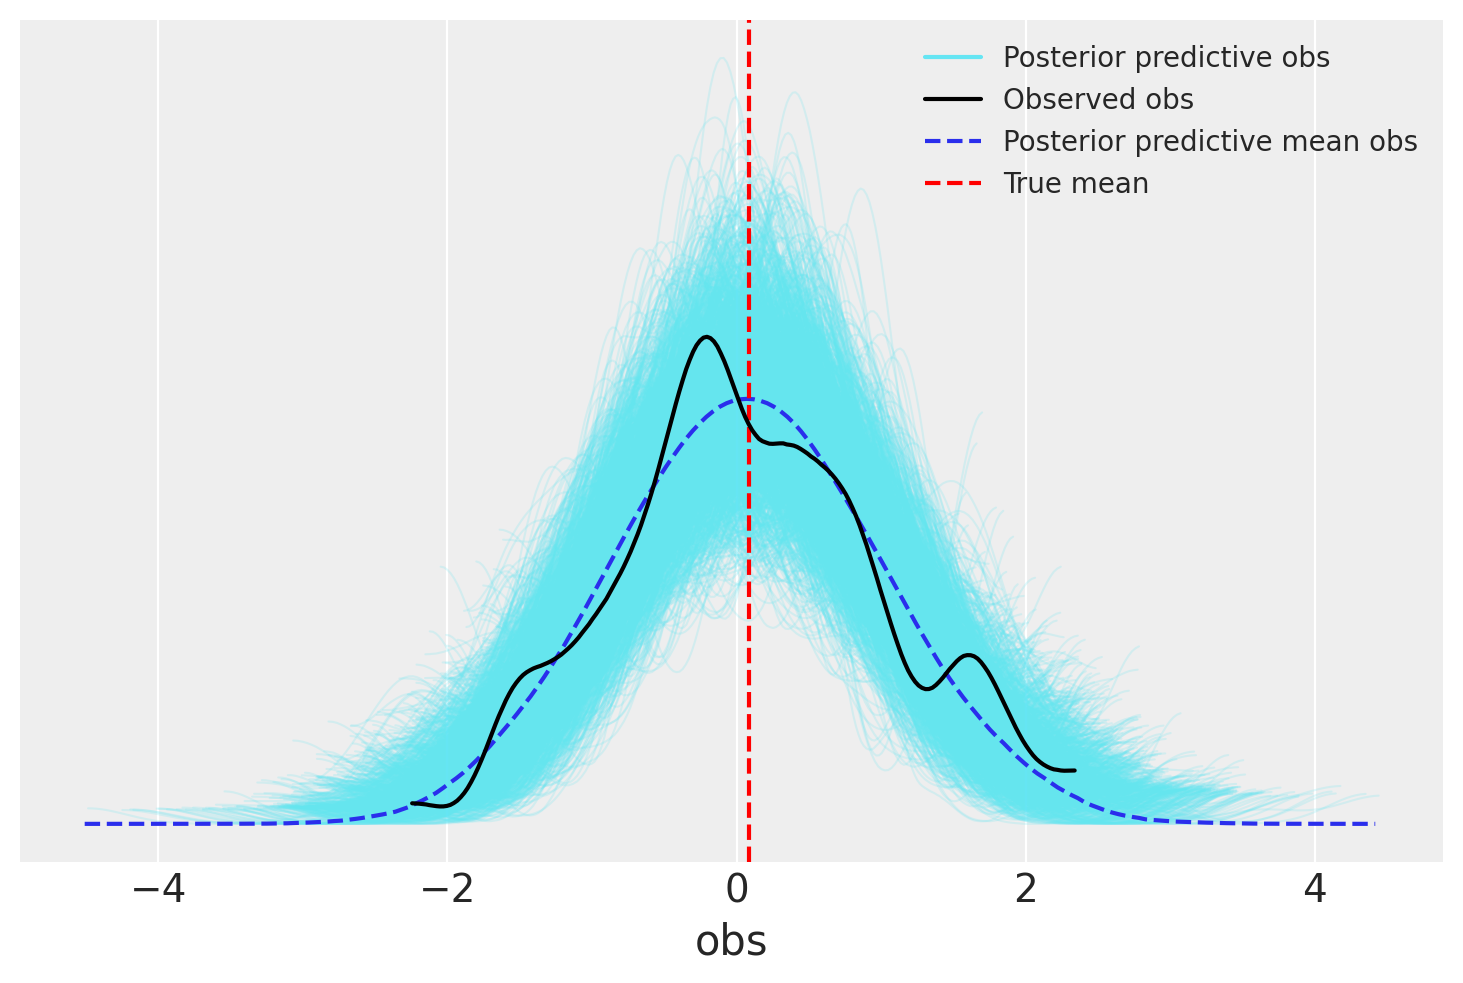

In [78]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);


Try hold-out data

In [79]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    # create shared variables
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared) # deterministic
    pm.Bernoulli("obs", p=logistic, observed = y_shared)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


We must now predict on unseen data. We need to change the values of `x_shared` and `y_shared`. Technically we are hoping to predict `y_shared`, so we only need to change `x_shared`, but ensure that the shape of `y_shared` is the same as that of `x_shared`.

What we are doing is getting a posterior distribution of `y` given `x`, for each input `x`.

In [80]:
with model:
    pm.set_data({
        "x_obs": [-1, 0, 1.0],
        "y_obs": [0, 0, 0], # dummy data
    })

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [89]:
# plt.hist(post_pred["obs"][:,2])

post_pred["obs"].mean(axis=0)

array([0.0225, 0.493 , 0.9765])